# Establishing a method for reliable registration of images with extremely sparse details

The new image registration method in *SuperTomo2* with its spatial masking and two-step aproach is extremely robust with most images, but I noticed that there are occasional issues with datasets containing very little details. 

In [45]:
%matplotlib inline
import os
import numpy

from ipywidgets import interact, fixed

from supertomo.io import image_data
from supertomo.ui import show

def show_axial_views(layer, data):
    show.display_2d_images(data[layer, :, :], numpy.amax(data[:],  axis=1),image1_title='XY', image2_title='XZ', vertical=True,)

def show_side_by_side(layer, image1, image2):
    show.display_2d_images(image1[layer, :, :], image2[layer, :, :], image1_title='Fixed', image2_title='Moving')

## Load Data

The *beads_crop.hdf5* contains 5 views of 120nm beads

In [46]:
working_directory ="/home/sami/Data/2016_12_tomoSTED_Nanoparticles"

data_file = "beads.hdf5"

full_path = os.path.join(working_directory,
                         data_file)

data = image_data.ImageData(full_path)


## Get two images to register

*fixed_image* is the regular STED image, whereas *moving_image* is the first rotated view.

In [47]:
fixed_index = 0
moving_index = 1
channel = 0
scale = 50
image_type = "original"

data.set_active_image(moving_index, channel, scale, image_type)
moving_image = data.get_itk_image()

data.set_active_image(fixed_index, channel, scale, image_type)
fixed_image = data.get_itk_image()

## Show *moving image*

The image is clearly tilted in ~30 degrees positive angle, as seen in the XZ axial view.

# Pre-rotate moving image

The orientation of the *moving image* can be roughly corrected by rotating it with the angle known from the experiment. 

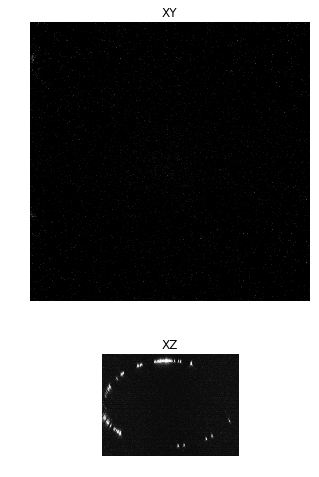

<function __main__.show_axial_views>

In [48]:

data.set_active_image(fixed_index, channel, scale, image_type)

interact(show_axial_views, layer=(0, data.get_image_size()[0]-1, 1) , data=fixed(data[:]))

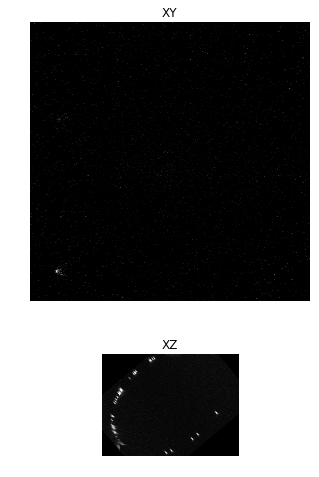

<function __main__.show_axial_views>

In [58]:
import SimpleITK as sitk
from supertomo.utils import itkutils

data.set_active_image(moving_index, channel, scale, image_type)

#rotation_angle = data.get_rotation_angle(radians=False)
rotation_angle = 320
y_offset = 0.0
x_offset = 0.0
z_offset = 0.0

rotation = (numpy.pi/180) * rotation_angle


rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint(
            [(index - 1) / 2.0 for index in moving_image.GetSize()])

manual_transform = sitk.Euler3DTransform()
manual_transform.SetCenter(rotation_center)
manual_transform.SetRotation(0, rotation, 0)
manual_transform.SetTranslation([y_offset, x_offset, z_offset])
modified_moving_image = itkutils.resample_image(moving_image, manual_transform)
    
interact(show_axial_views, 
         layer=(0, modified_moving_image.GetDepth()-1, 1), 
         data=fixed(itkutils.convert_to_numpy(modified_moving_image)[0]))

Continue with the centered transform initializer. The images are already very well overlaid.

# Create a binary mask for the similarity metric

Because both of the images are nearly empty, the sampling-based similarity metric does not work on the entire images. One can fix this by defining which regions of the image should be used for similarity calculation. The required spatial mask is calculated here.

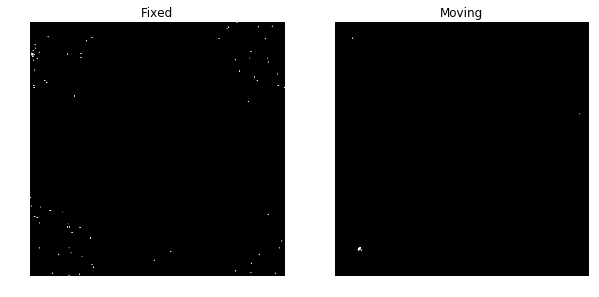

<function __main__.show_side_by_side>

In [59]:
registration = sitk.ImageRegistrationMethod()

fixed_mask = sitk.BinaryDilate(sitk.BinaryThreshold(fixed_image, 0, 25, 0, 1))
moving_mask = sitk.BinaryDilate(sitk.BinaryThreshold(modified_moving_image, 0, 25, 0, 1))

interact(show_side_by_side, 
         layer=(0, fixed_mask.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_mask)[0]),
         image2=fixed(itkutils.convert_to_numpy(moving_mask)[0])
         
        )

# Run initialization

The registration is started by calculating an initial transform that roughly overlays the moving and the fixed image. Please notice that the pre-rotated moving image is used here. An **affine** transform is used, because there is some deformation in the acquired images.

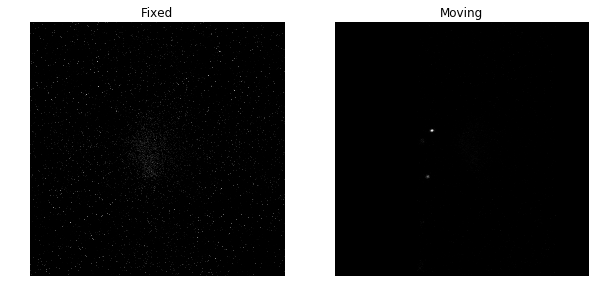

In [60]:
transform = sitk.CenteredTransformInitializer(
                fixed_image,
                modified_moving_image,
                sitk.AffineTransform(3),
                sitk.CenteredTransformInitializerFilter.MOMENTS
            )


initialized_moving_image = itkutils.resample_image(modified_moving_image, transform, fixed_image)

interact(show_side_by_side, 
         layer=(0, initialized_moving_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(initialized_moving_image)[0])
         
        )

# Run registration

The registration is run here. The *optimizer scales* and the learning rate are now estimated automatically.  

In [61]:
learning_rate = 1
min_step = 0.0005
max_iterations = 300
relaxation_factor = 0.8

mattes_histogram_bins = 30
mattes_sampling_percentage = 1


#Optimizer
registration.SetOptimizerAsRegularStepGradientDescent(
    learning_rate,
    min_step,
    max_iterations,
    relaxationFactor=relaxation_factor,
    estimateLearningRate=registration.EachIteration
    
)

registration.SetOptimizerScalesFromJacobian()

#Interpolator
registration.SetInterpolator(sitk.sitkLinear)

#Metric
#registration.SetMetricAsMattesMutualInformation(mattes_histogram_bins)

registration.SetMetricAsCorrelation()
registration.SetMetricSamplingStrategy(registration.RANDOM)
registration.SetMetricSamplingPercentage(mattes_sampling_percentage)

#Mask
registration.SetMetricFixedMask(fixed_mask)
registration.SetMetricMovingMask(moving_mask)


# Initial transform
registration.SetInitialTransform(transform)

final_transform = registration.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                       sitk.Cast(modified_moving_image, sitk.sitkFloat32))

print final_transform


itk::simple::Transform
 AffineTransform (0x64ebae0)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 3
   Modified Time: 5334851
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00786 0.00154157 -0.00275819 
     0.0078155 0.995306 0.0154104 
     0.00541019 -0.00499728 0.981665 
   Offset: [-0.414851, -0.776463, 1.98951]
   Center: [23.3052, 25.6921, 16.9868]
   Translation: [-0.238868, -0.453158, 1.67575]
   Inverse: 
     0.992196 -0.00152264 0.00281168 
     -0.00770581 1.00465 -0.0157929 
     -0.00550746 0.00512268 1.01858 
   Singular: 0



In [62]:
print('Final metric value: {0}'.format(registration.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration.GetOptimizerStopConditionDescription()))

Final metric value: -0.0314912626241
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 27 iterations. Current step (0.000414177) is less than minimum step (0.0005).


# Show results

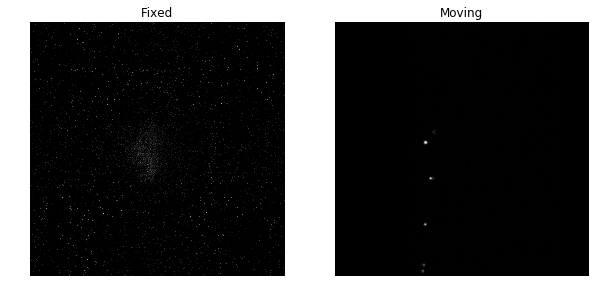

In [63]:
result_image = itkutils.resample_image(modified_moving_image, final_transform, fixed_image)

interact(show_side_by_side, 
         layer=(0, fixed_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(result_image)[0])
         
        )


In [15]:

result = itkutils.make_composite_rgb_image(fixed_image, result_image, return_numpy=True)[0]

show.evaluate_3d_image(result)